In [78]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.pipeline import Pipeline

from collections import Counter
import matplotlib.pyplot as plt

import joblib

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import preprocessing_utils as preproc
from preprocessing_utils import generate_recurrence_labels
import config

In [79]:
# # Loading in the mRNA and clinical data:
# clinical_df = pd.read_csv("../ucec_tcga_pan_can_atlas_2018\data_clinical_patient.txt", sep="\t", comment="#", low_memory=False)
# clinical_df = clinical_df.set_index('PATIENT_ID')

# mrna_df = pd.read_csv("../ucec_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt", sep="\t", comment="#")

# # There are 527 patients in the mRNA and 529 patients in the clinical data

# # The first 2 columns of the mRNA data are labels (Hugo_Symbol then Entrez_Gene_Id). 
# # 13 of the genes do not have Hugo_symbols, so for these I will you the Entrex_Gene_Id as the label.
# missing_symbols = mrna_df['Hugo_Symbol'].isnull()
# mrna_df.loc[missing_symbols, 'Hugo_Symbol'] = mrna_df.loc[missing_symbols, 'Entrez_Gene_Id'].astype(str)

# # There are 7 rows that have both the same Hugo_Symbol and Entrez_Gene_Id but different values for the patients.
# # I will rename these rows to have unique labels by appending -1-of-2 and -2-of-2 to the Hugo_Symbol.
# # Get value counts
# counts = mrna_df['Hugo_Symbol'].value_counts()

# # Generate unique labels for duplicates
# def label_duplicates(value, index):
#     if counts[value] == 1:
#         return value  # Keep unique values unchanged
#     occurrence = mrna_df.groupby('Hugo_Symbol').cumcount() + 1  # Count occurrences per group
#     return f"{value}-{occurrence[index]}-of-{counts[value]}"

# # Apply the labeling function
# mrna_df['Hugo_Symbol'] = [label_duplicates(value, idx) for idx, value in mrna_df['Hugo_Symbol'].items()]

# mrna_df = mrna_df.set_index('Hugo_Symbol')
# mrna_df = mrna_df.drop(columns="Entrez_Gene_Id") # removing the label column before I transpose the df
# mrna_df= mrna_df.transpose() # now the patients are the index and the genes are the columns
# mrna_df.index = [id[:-3] for id in mrna_df.index] # removes extranious -01 so that the patient ids match the clinical data


In [80]:
# labels = generate_recurrence_labels(
#     treatment_file=,
#     status_file="../ucec_tcga_pan_can_atlas_2018/data_timeline_status.txt",
#     clinical_file="../ucec_tcga_pan_can_atlas_2018/data_clinical_patient.txt"
# )

# clinical_df, mrna_df, labels = preproc.drop_patients_missing_data(clinical_df, mrna_df, labels)

# clinical_cols = clinical_df.columns.tolist()
# mrna_cols = mrna_df.columns.tolist()
# full_df = clinical_df.join(mrna_df, how="inner")

# X_train, X_test, y_train, y_test = train_test_split(full_df, labels, test_size=0.2, random_state=config.SEED, stratify=labels)

# # these are all DateFrames
# print(type(X_train), X_train.shape)
# print(type(X_test), X_test.shape)
# print(type(y_train), y_train.shape)
# print(type(y_test), y_test.shape)

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("clinical", preproc.ClinicalPreprocessorWrapper(
#             cols_to_remove=config.CLINICAL_COLS_TO_REMOVE,
#             categorical_cols=config.CATEGORICAL_COLS,
#             max_null_frac=config.CLINICAL_MAX_NULL_FRAC,
#             uniform_thresh=config.CLINICAL_UNIFORM_THRESH
#         ), clinical_cols),

#         ("mrna", preproc.MrnaPreprocessorWrapper(
#             max_null_frac=config.MAX_NULL_FRAC,
#             uniform_thresh=config.UNIFORM_THRESHOLD,
#             corr_thresh=config.CORRELATION_THRESHOLD,
#             var_thresh=config.VARIANCE_THRESHOLD,
#             re_run_pruning=config.RE_RUN_PRUNING,
#             literature_genes=config.LITERATURE_GENES,
#             correlated_genes_path=config.CORRELATED_GENES_PATH,
#             use_stability_selection=config.USE_STABILITY_SELECTION,
#             n_boots=config.N_BOOTS,
#             fpr_alpha=config.FPR_ALPHA,
#             stability_threshold=config.STABILITY_THRESHOLD,
#             random_state=config.SEED
#         ), mrna_cols),
#     ]
# )



In [81]:
# ### THIS IS CODE TO GENERATE DATA FOR LATER USE FROM PREPROCESSING (but, it might not be doing great)

# # --- Step 6: Fit the preprocessor on training data ---
# preprocessor.fit(X_train, y_train)

# # --- Step 7: Transform train and test data ---
# X_train_preprocessed = pd.DataFrame(
#     preprocessor.transform(X_train),
#     index=X_train.index,
#     columns=preprocessor.get_feature_names_out()
# )

# X_test_preprocessed = pd.DataFrame(
#     preprocessor.transform(X_test),
#     index=X_test.index,
#     columns=preprocessor.get_feature_names_out()
# )

# # # --- Step 8: Save preprocessed data and labels ---
# joblib.dump(X_train_preprocessed, "../data/no_boot/X_train.pkl")
# joblib.dump(X_test_preprocessed, "../data/no_boot/X_test.pkl")
# joblib.dump(y_train, "../data/no_boot/y_train.pkl")
# joblib.dump(y_test, "../data/no_boot/y_test.pkl")
# joblib.dump(preprocessor, "../data/no_boot/preprocessor.pkl")  # Save preprocessor for future use


In [82]:
# # a little cautionary testing

# # Ensure all column names are strings
# non_str_cols = [col for col in X_train.columns if not isinstance(col, str)]
# if non_str_cols:
#     raise TypeError(f"Non-string column names found: {non_str_cols}")

# def check_feature_alignment(X_train, X_test):
#     train_cols = list(X_train.columns)
#     test_cols = list(X_test.columns)

#     missing = set(train_cols) - set(test_cols)
#     extra = set(test_cols) - set(train_cols)

#     if missing or extra:
#         raise ValueError(
#             f"Feature mismatch!\n"
#             f"Missing in test: {missing}\n"
#             f"Extra in test: {extra}\n"
#         )

#     if train_cols != test_cols:
#         raise ValueError("Feature names match, but column order is different!")

#     print("✅ Features aligned: same names and order")

# check_feature_alignment(X_train, X_test)

# # variances = X_train.var(axis=0)
# # constant_features = variances[variances == 0].index.tolist()
# # if len(constant_features) > 0:
# #     raise ValueError("constant features, oh no")

In [83]:
# preprocessor.set_output(transform="pandas")

# def run_LASSO():
#     print("Running Logistic Regression with LASSO")

#     pipeline = Pipeline([
#         ('preprocessor', preprocessor),
#         ("selector", preproc.BootstrappedSelectKBest(k=100, n_bootstrap=50, threshold=0.4, random_state=config.SEED)),
#         ('clf', LogisticRegression(
#             penalty='l1',
#             solver='saga',
#             class_weight='balanced',      # helps with imbalance
#             random_state=config.SEED,
#             max_iter=20000,               # more iterations for convergence
#             n_jobs=-1,                    # parallelize
#             tol=1e-3,
#             verbose=0
#         ))
#     ])

#     param_grid = {
#         # Regularization strength (C smaller = stronger shrinkage)
#         'clf__C': [0.1],
#     }

#     return pipeline, param_grid

# pipeline, param_grid = run_LASSO()


# # Set up cross-validation
# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=config.SEED)

# # Grid search over pipeline
# grid_search = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     cv=cv,
#     scoring='roc_auc',  # could experiment with 'f1' if recurrence class is more important
#     n_jobs=1,
#     verbose=3
# )

# # # Fit pipeline on training data
# grid_search = grid_search.fit(X_train, y_train)

# best_model = grid_search.best_estimator_


In [84]:
X_train = joblib.load("../data/mutation/X_train.pkl")
y_train = joblib.load("../data/mutation/y_train.pkl")
X_test = joblib.load("../data/mutation/X_test.pkl")
y_test = joblib.load("../data/mutation/y_test.pkl")

print(len(X_train.columns))

def check_constant_features(X):
    """
    Identify constant (zero-variance) features in a DataFrame.
    
    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix
    
    Returns
    -------
    constant_features : list
        List of column names that are constant
    """
    constant_features = X.columns[X.nunique(dropna=False) <= 1].tolist()
    if constant_features:
        print(f"Found {len(constant_features)} constant features: {constant_features[:10]}{'...' if len(constant_features) > 10 else ''}")
    else:
        print("No constant features found.")
    return constant_features
constant_features_train = check_constant_features(X_train)

from sklearn.feature_selection import VarianceThreshold

def print_low_variance_features(X, threshold=1e-5):
    """
    Print features with variance below the given threshold.
    """
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(X)

    # Mask of features that would be dropped
    mask = ~selector.get_support()

    # Extract low-variance features
    low_var_features = X.columns[mask]

    print(f"Number of features below variance {threshold}: {len(low_var_features)}")
    print(low_var_features.tolist())

    return low_var_features

# Example usage:
low_variance_features_train = print_low_variance_features(X_train, threshold=1e-5)


18134
No constant features found.
Number of features below variance 1e-05: 0
[]


In [85]:
def run_LASSO():
    print("Running Logistic Regression with LASSO")
    pipeline = Pipeline([
        # ("selector", preproc.BootstrappedSelectKBest(k=100, n_bootstrap=50, threshold=0.4, random_state=config.SEED)),
        # ("selector", preproc.StabilitySelection(n_boots=100, fpr_alpha=0.05, stability_threshold=0.8, random_state=config.SEED)),
        ('clf', LogisticRegression(
            penalty='l1',
            solver='saga',
            class_weight='balanced',      # helps with imbalance
            random_state=config.SEED,
            max_iter=20000,               # more iterations for convergence
            n_jobs=-1,                    # parallelize
            tol=1e-3,
            verbose=0
        ))
    ])

    param_grid = {
        # Regularization strength (C smaller = stronger shrinkage)
        'clf__C': [0.01, 0.1, 0.5, 1, 5, 10],
    }

    return pipeline, param_grid

def run_Dummy():
    print("Running Dummy Classifier (baseline check)")
    pipeline = Pipeline([
        ('clf', DummyClassifier(
            strategy="most_frequent",  # or "stratified", "uniform", etc.
            random_state=config.SEED
        ))
    ])
    
    # DummyClassifier doesn’t really have useful hyperparams for grid search,
    # but we’ll keep param_grid consistent with the LASSO setup.
    param_grid = {
        'clf__strategy': ["most_frequent", "stratified", "uniform"]
    }
    
    return pipeline, param_grid


In [86]:
def run_XGBoost_from_LASSO(X=None, y=None, seed=42):
    """
    Load a pre-trained LASSO model, extract top_k features,
    and return an XGBoost pipeline + param_grid.
    
    Args:
        lasso_model_path: str, path to saved LASSO model
        X: pd.DataFrame, feature matrix used for training (for column names)
        top_k: int, number of top features to select
        seed: int, random seed
    
    Returns:
        pipeline, param_grid, selected_features
    """
    
    # Compute scale_pos_weight for imbalance
    pos = np.sum(y == 1)
    neg = np.sum(y == 0)
    scale_pos_weight = neg / pos if pos > 0 else 1.0
    
    # Define XGBoost pipeline
    xgb_clf = XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=seed,
        n_jobs=1,
        tree_method="hist",  # use "gpu_hist" if GPU available
        scale_pos_weight=scale_pos_weight,
        verbosity=3
    )
    
    pipeline = Pipeline([
        ("clf", xgb_clf)
    ])
    
    # Small param grid to start
    param_grid = {
        "clf__n_estimators": [50],
        "clf__max_depth": [3, 5],
        "clf__learning_rate": [0.01, 0.1],
        "clf__subsample": [0.6, 0.8],
        "clf__colsample_bytree": [0.5]
    }
    
    return pipeline, param_grid


In [87]:

def quick_XGBoost_test(lasso_model_path, X, y, top_k=500, seed=42):
    """
    Quick run of XGBoost using top features from pretrained LASSO model.
    No GridSearchCV, just a single fit to check runtime + accuracy.
    
    Args:
        lasso_model_path: str, path to saved LASSO model
        X: pd.DataFrame, features
        y: pd.Series or np.array, labels
        top_k: int, number of top features to keep
        seed: int, random seed
    
    Returns:
        model: trained XGBClassifier
        selected_features: list of chosen features
    """
    # Load pretrained LASSO
    lasso_model = joblib.load(lasso_model_path)
    coefs = lasso_model.named_steps["clf"].coef_.ravel()
    
    # Get top features
    abs_coefs = np.abs(coefs)
    top_idx = np.argsort(abs_coefs)[-top_k:]
    selected_features = X.columns[top_idx]
    
    # Subset X to those features
    X_sub = X[selected_features]

    # Compute scale_pos_weight for imbalance
    pos = np.sum(y == 1)
    neg = np.sum(y == 0)
    scale_pos_weight = neg / pos if pos > 0 else 1.0
    print(f"⚖️ scale_pos_weight set to {scale_pos_weight:.2f} (neg={neg}, pos={pos})")

    
    # Define a lightweight XGBoost model
    model = XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.5,
        random_state=seed,
        n_jobs=-1,
        tree_method="hist",  # or "gpu_hist" if you have GPU
        scale_pos_weight=scale_pos_weight
    )
    
    # Fit on data
    model.fit(X_sub, y)
    
    print(f"✅ Trained XGBoost on {X_sub.shape[1]} selected features")
    return model, selected_features

model, top_features = quick_XGBoost_test(
    "../models/LASSO_with_mutation",
    X_train,
    y_train,  # labels
    top_k=500
)



⚖️ scale_pos_weight set to 4.47 (neg=295, pos=66)
✅ Trained XGBoost on 500 selected features


In [88]:
from sklearn.metrics import make_scorer, roc_auc_score

# Load saved LASSO model
model = joblib.load("../models/LASSO_with_mutation")

# Extract coefficients
coefs = model.named_steps["clf"].coef_.ravel()
feature_names = X_train.columns
abs_coefs = np.abs(coefs)

# Select top_k features
top_idx = np.argsort(abs_coefs)[-500:] # only going to use the top 500 features selected by LASSO
selected_features = feature_names[top_idx]


# CHANGE MODEL HERE ######################################################
pipeline, param_grid = run_XGBoost_from_LASSO(
    X=X_train[selected_features],
    y=y_train,
    seed=42)

class ProgressStratifiedKFold(StratifiedKFold):
    def __init__(self, n_splits=5, **kwargs):
        super().__init__(n_splits=n_splits, **kwargs)
        self.fold = 0

    def split(self, X, y, groups=None):
        for train, test in super().split(X, y, groups):
            self.fold += 1
            print(f"[CV] Starting fold {self.fold}/{self.n_splits}", flush=True)
            yield train, test

class FoldLogger:
    def __init__(self):
        self.fold = 0

    def __call__(self, estimator, X, y):
        """This function will be called after each fold finishes scoring."""
        self.fold += 1
        print(f"✅ Finished fold {self.fold}")
        return roc_auc_score(y, estimator.predict_proba(X)[:, 1])

fold_logger = FoldLogger()
scorer = make_scorer(fold_logger, needs_proba=True)

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring=scorer,
    cv=3,
    verbose=2,
    n_jobs=-1
)


# Set up cross-validation
cv = ProgressStratifiedKFold(n_splits=3, shuffle=True, random_state=config.SEED)

# Grid search over pipeline
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # Or 'f1' if recurrence class is more important
    n_jobs=-1,
    verbose=2
)

# Fit pipeline on training data
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] Starting fold 1/3
[CV] Starting fold 2/3
[CV] Starting fold 3/3
[11:47:30] ======== Monitor (0): HostSketchContainer ========
[11:47:30] AllReduce: 0.301963s, 1 calls @ 301963us

[11:47:30] MakeCuts: 0.38812s, 1 calls @ 388120us

[11:47:32] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (361, 18134, 6546374).
[11:47:32] DEBUG: C:\actions-runner\_work\xgboost\xgboost\src\gbm\gbtree.cc:131: Using tree method: 3
[11:47:59] ======== Monitor (0): GBTree ========
[11:47:59] BoostNewTrees: 25.9585s, 50 calls @ 25958461us

[11:47:59] CommitModel: 5.8e-05s, 50 calls @ 58us

[11:47:59] ======== Monitor (0): HistUpdater ========
[11:47:59] BuildHistogram: 5.80818s, 100 calls @ 5808179us

[11:47:59] EvaluateSplits: 17.2011s, 150 calls @ 17201074us

[11:47:59] InitData: 0.037432s, 50 calls @ 37432us

[11:47:59] InitRoot: 5.66842s, 50 calls @ 5668421us

[11:

In [89]:
# # THIS IS A FIXED PIPELINE (NO GRID SEARCH) -----------------------------------------------------
# #  with selectKBest instead of bootstrapping this got an AUROC of 0.646 on test set

# from sklearn.metrics import classification_report, roc_auc_score

# # Load pre-saved data
# # X_train = joblib.load("../new_data/X_train.pkl")
# # y_train = joblib.load("../new_data/y_train.pkl")
# # X_test = joblib.load("../new_data/X_test.pkl")
# # y_test = joblib.load("../new_data/y_test.pkl")

# # Build LASSO pipeline with preprocessing
# pipeline = Pipeline([
#     ("preprocessor", preprocessor),
#     ('variance_threshold', VarianceThreshold(threshold=0.001)),
#     ('select', SelectKBest(score_func=f_classif, k=50)),
#     ("clf", LogisticRegression(
#         penalty='l1',
#         solver='saga',
#         class_weight='balanced',
#         random_state=config.SEED,
#         max_iter=10000,
#         verbose=1,
#         C=5  # Fixed C
#     ))
# ])

# # Fit pipeline on training data
# pipeline.fit(X_train, y_train)

# # Predict and evaluate
# y_pred = pipeline.predict(X_test)
# y_proba = pipeline.predict_proba(X_test)[:, 1]

# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# print("AUC-ROC:", roc_auc_score(y_test, y_proba))


In [90]:
print("Overall best params:", grid_search.best_params_, "\n")

# Retrieve the results from grid search
cv_results = grid_search.cv_results_

# Extract the mean test scores for each parameter combination
mean_test_scores = cv_results['mean_test_score']

# Extract the standard deviation of test scores for each parameter combination
std_test_scores = cv_results['std_test_score']

# Extract the parameter settings for each run
params = cv_results['params']

# Print the AUC-ROC scores for each parameter combination
for mean, std, param in zip(mean_test_scores, std_test_scores, params):
    print(f"Parameters: {param}")
    print(f"Mean AUC-ROC: {mean:.4f}")
    print(f"Standard Deviation: {std:.4f}")
    print("-" * 30)


Overall best params: {'clf__colsample_bytree': 0.5, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 50, 'clf__subsample': 0.8} 

Parameters: {'clf__colsample_bytree': 0.5, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 50, 'clf__subsample': 0.6}
Mean AUC-ROC: 0.6438
Standard Deviation: 0.0283
------------------------------
Parameters: {'clf__colsample_bytree': 0.5, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 50, 'clf__subsample': 0.8}
Mean AUC-ROC: 0.6602
Standard Deviation: 0.0196
------------------------------
Parameters: {'clf__colsample_bytree': 0.5, 'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__n_estimators': 50, 'clf__subsample': 0.6}
Mean AUC-ROC: 0.6420
Standard Deviation: 0.0276
------------------------------
Parameters: {'clf__colsample_bytree': 0.5, 'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__n_estimators': 50, 'clf__subsample': 0.8}
Mean AUC-ROC: 0.6553
Standard Deviation: 0.0148
----

[11:48:00] DEBUG: C:\actions-runner\_work\xgboost\xgboost\src\gbm\gbtree.cc:131: Using tree method: 3
Training Data Evaluation Metrics:
True Positives (TP): 66
False Positives (FP): 2
True Negatives (TN): 293
False Negatives (FN): 0
Precision: 0.971
Recall: 1.000
AUC-ROC Score: 0.9999


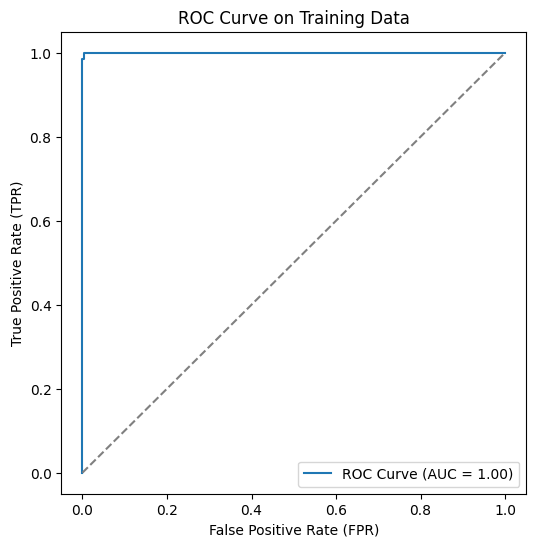

In [91]:
# Training Data Evaluation Metrics

# Predictions (discrete)
y_train_pred = best_model.predict(X_train)

print("Training Data Evaluation Metrics:")

# Confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = cm_train.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Precision & Recall
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

# Continuous scores for AUROC
if hasattr(best_model, "predict_proba"):
    y_scores = best_model.predict_proba(X_train)[:, 1]
elif hasattr(best_model, "decision_function"):
    y_scores = best_model.decision_function(X_train)
else:
    y_scores = y_train_pred  # fallback (not ideal)

# AUROC
roc_auc = roc_auc_score(y_train, y_scores)
print(f"AUC-ROC Score: {roc_auc:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_train, y_scores)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve on Training Data")
plt.legend()
plt.show()

Testing Data Evaluation Metrics:
True Positives (TP): 1
False Positives (FP): 6
True Negatives (TN): 68
False Negatives (FN): 16
Precision: 0.143
Recall: 0.059
AUC-ROC Score: 0.6518


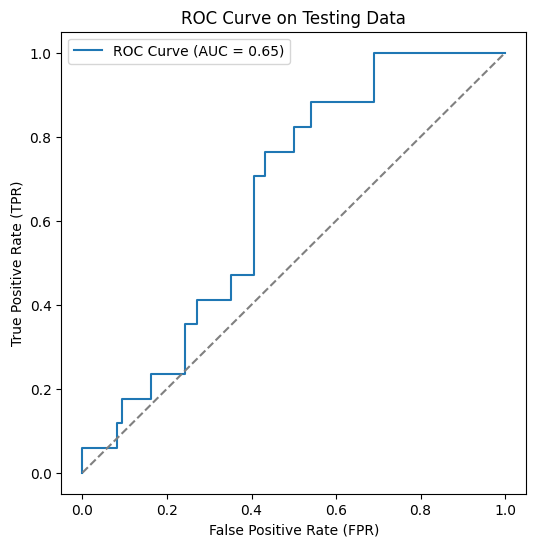

In [92]:
# Test Data Evaluation Metrics

# Predictions (discrete)
y_test_pred = best_model.predict(X_test)

print("Testing Data Evaluation Metrics:")

# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm_test.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Precision & Recall
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

# Continuous scores for AUROC
if hasattr(best_model, "predict_proba"):
    y_scores = best_model.predict_proba(X_test)[:, 1]
elif hasattr(best_model, "decision_function"):
    y_scores = best_model.decision_function(X_test)
else:
    y_scores = y_test_pred  # fallback (not ideal)

# AUROC
roc_auc = roc_auc_score(y_test, y_scores)
print(f"AUC-ROC Score: {roc_auc:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve on Testing Data")
plt.legend()
plt.show()

In [93]:
# #Save the best estimator from GridSearchCV
# joblib.dump(best_model, "../models/LASSO_with_mutation") # change the path depending on the model

Testing Data Evaluation Metrics:
True Positives (TP): 1
False Positives (FP): 6
True Negatives (TN): 68
False Negatives (FN): 16
Precision: 0.143
Recall: 0.059
AUC-ROC Score: 0.6518


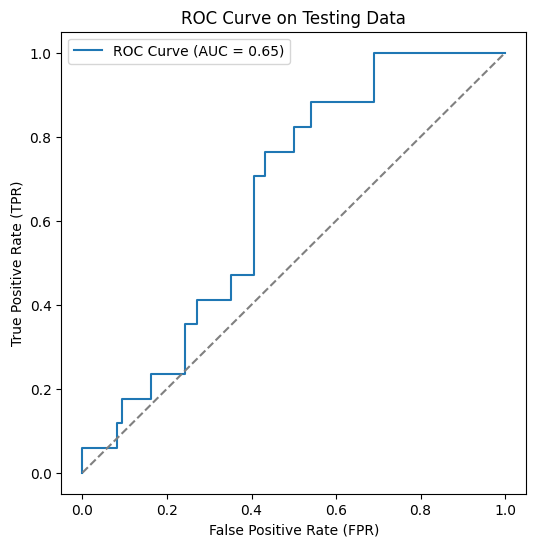

In [94]:
# Test Data Evaluation Metrics

# Predictions (discrete)
y_test_pred = best_model.predict(X_test)

# Custom threshold
threshold = 0.4
y_test_pred = (y_test_pred >= threshold).astype(int)

print("Testing Data Evaluation Metrics:")

# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm_test.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Precision & Recall
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

# Continuous scores for AUROC
if hasattr(best_model, "predict_proba"):
    y_scores = best_model.predict_proba(X_test)[:, 1]
elif hasattr(best_model, "decision_function"):
    y_scores = best_model.decision_function(X_test)
else:
    y_scores = y_test_pred  # fallback (not ideal)

# AUROC
roc_auc = roc_auc_score(y_test, y_scores)
print(f"AUC-ROC Score: {roc_auc:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve on Testing Data")
plt.legend()
plt.show()